# Connecting In-School Support to Student Learning and Success
### Importing the packages and libraries

In [120]:
install.packages("cowplot")
install.packages("kknn")
install.packages("GGally")
install.packages('tidyverse')
library(kknn)
library(GGally)


The downloaded binary packages are in
	/var/folders/fb/5nf2l6vx4tj8839ndlppjshw0000gn/T//RtmpyXYjmd/downloaded_packages

The downloaded binary packages are in
	/var/folders/fb/5nf2l6vx4tj8839ndlppjshw0000gn/T//RtmpyXYjmd/downloaded_packages

The downloaded binary packages are in
	/var/folders/fb/5nf2l6vx4tj8839ndlppjshw0000gn/T//RtmpyXYjmd/downloaded_packages

The downloaded binary packages are in
	/var/folders/fb/5nf2l6vx4tj8839ndlppjshw0000gn/T//RtmpyXYjmd/downloaded_packages


In [121]:
#import libraries
install.packages("themis")
library(tidyverse)
library(broom)
library(repr)
options(repr.matrix.max.rows = 6)
library(readxl)
library(ggplot2)
library(cowplot)
install.packages("infer")


The downloaded binary packages are in
	/var/folders/fb/5nf2l6vx4tj8839ndlppjshw0000gn/T//RtmpyXYjmd/downloaded_packages

The downloaded binary packages are in
	/var/folders/fb/5nf2l6vx4tj8839ndlppjshw0000gn/T//RtmpyXYjmd/downloaded_packages


## Introduction
Enhancing educational systems requires a deep comprehension of methods to assist children and teenagers in learning more efficiently and engaging thoroughly in their education. An approach to achieve this could be fostering robust connections between students and teachers. This is based on the idea that students benefit greatly when they perceive their teachers as being invested in them, demonstrating that the educators are aware of and care about their students(Klem et al., 2004, pg. 1). Moreover, according to Klem et al.(2004), students who received additional support from school felt more engaged and, as a result, showed a higher level of academic performance. To gather more information around this subject, we are analyzing data from UC Irivne Machine Learning Repository of 649 Portuguese secondary schoolers to investigate whether students who received extra support from school have on average different than students who did not, along with building a confidence interval of difference of mean in order to confirm our finding

### Dataset background
The data attributes include student grades, demographic, social and school-related features. In our study, we focus on the variables of "G3 (final grade)" and “schoolsup (extra educational support)”. We want to use this sample to infer the parameter of all high-school students in Alentejo region of Portuguese. 

The dataset was collected at two random public schools from the Alentejo region of Portuguese by using school reports and questionnaires. Since the sample size is relatively large (n=649), and there is no bias in selecting schools. Then, we can say the sample is representative of the population of Portuguese student in the Alentejo region. Any result based on the sample can generalize to the population, and the point estimate is a “good guess” of the unknown population parameter. Thus, we can conclude that the report is trustworthy.

### Import dataset

In [122]:
studenturl<- "https://archive.ics.uci.edu/static/public/320/student+performance.zip"
temp <- tempfile()
download.file(studenturl,temp)
studentzip <- unzip(temp, "student.zip")
studentfile <- unzip(studentzip,"student-por.csv")
student <- read_csv2(studentfile, col_names = TRUE)

student

ℹ Using "','" as decimal and "'.'" as grouping mark. Use `read_delim()` for more control.

Rows: 649 Columns: 33
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr (17): school, sex, address, famsize, Pstatus, Mjob, Fjob, reason, guardi...
dbl (16): age, Medu, Fedu, traveltime, studytime, failures, famrel, freetime...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,⋯,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GP,F,18,U,GT3,A,4,4,at_home,teacher,⋯,4,3,4,1,1,3,4,0,11,11
GP,F,17,U,GT3,T,1,1,at_home,other,⋯,5,3,3,1,1,3,2,9,11,11
GP,F,15,U,LE3,T,1,1,at_home,other,⋯,4,3,2,2,3,3,6,12,13,12
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
MS,F,18,U,GT3,T,1,1,other,other,⋯,1,1,1,1,1,5,6,11,12,9
MS,M,17,U,LE3,T,3,1,services,services,⋯,2,4,5,3,4,2,6,10,10,10
MS,M,18,R,LE3,T,3,2,services,other,⋯,4,4,1,3,4,5,4,10,11,11


<em>Table 1: Student Performance's raw dataset</em>

### Clean and wrangle dataset

In [123]:
#Select variables that is needed for the dataset, along with filtering out any data points that is not available
clean_student <- student %>%
                  select(schoolsup,G3)%>%
                  filter(!is.na(schoolsup),!is.na(G3))
clean_student

schoolsup,G3
<chr>,<dbl>
yes,11
no,11
yes,12
⋮,⋮
no,9
no,10
no,11


<em>Table 2: Student Performance's refined dataset</em>

## Preliminary results

In [124]:
#Summary of relevant statistic in the sample
summary_student <- clean_student %>%
                   group_by(schoolsup)%>%
                   summarize(mean_final_grade = mean(G3),
                            sd = sd(G3),
                            n = n())
summary_student

schoolsup,mean_final_grade,sd,n
<chr>,<dbl>,<dbl>,<int>
no,11.97935,3.316040,581
yes,11.27941,2.304088,68


<em>Table 3: Statistical summary of the sample</em>

### Plot the raw data

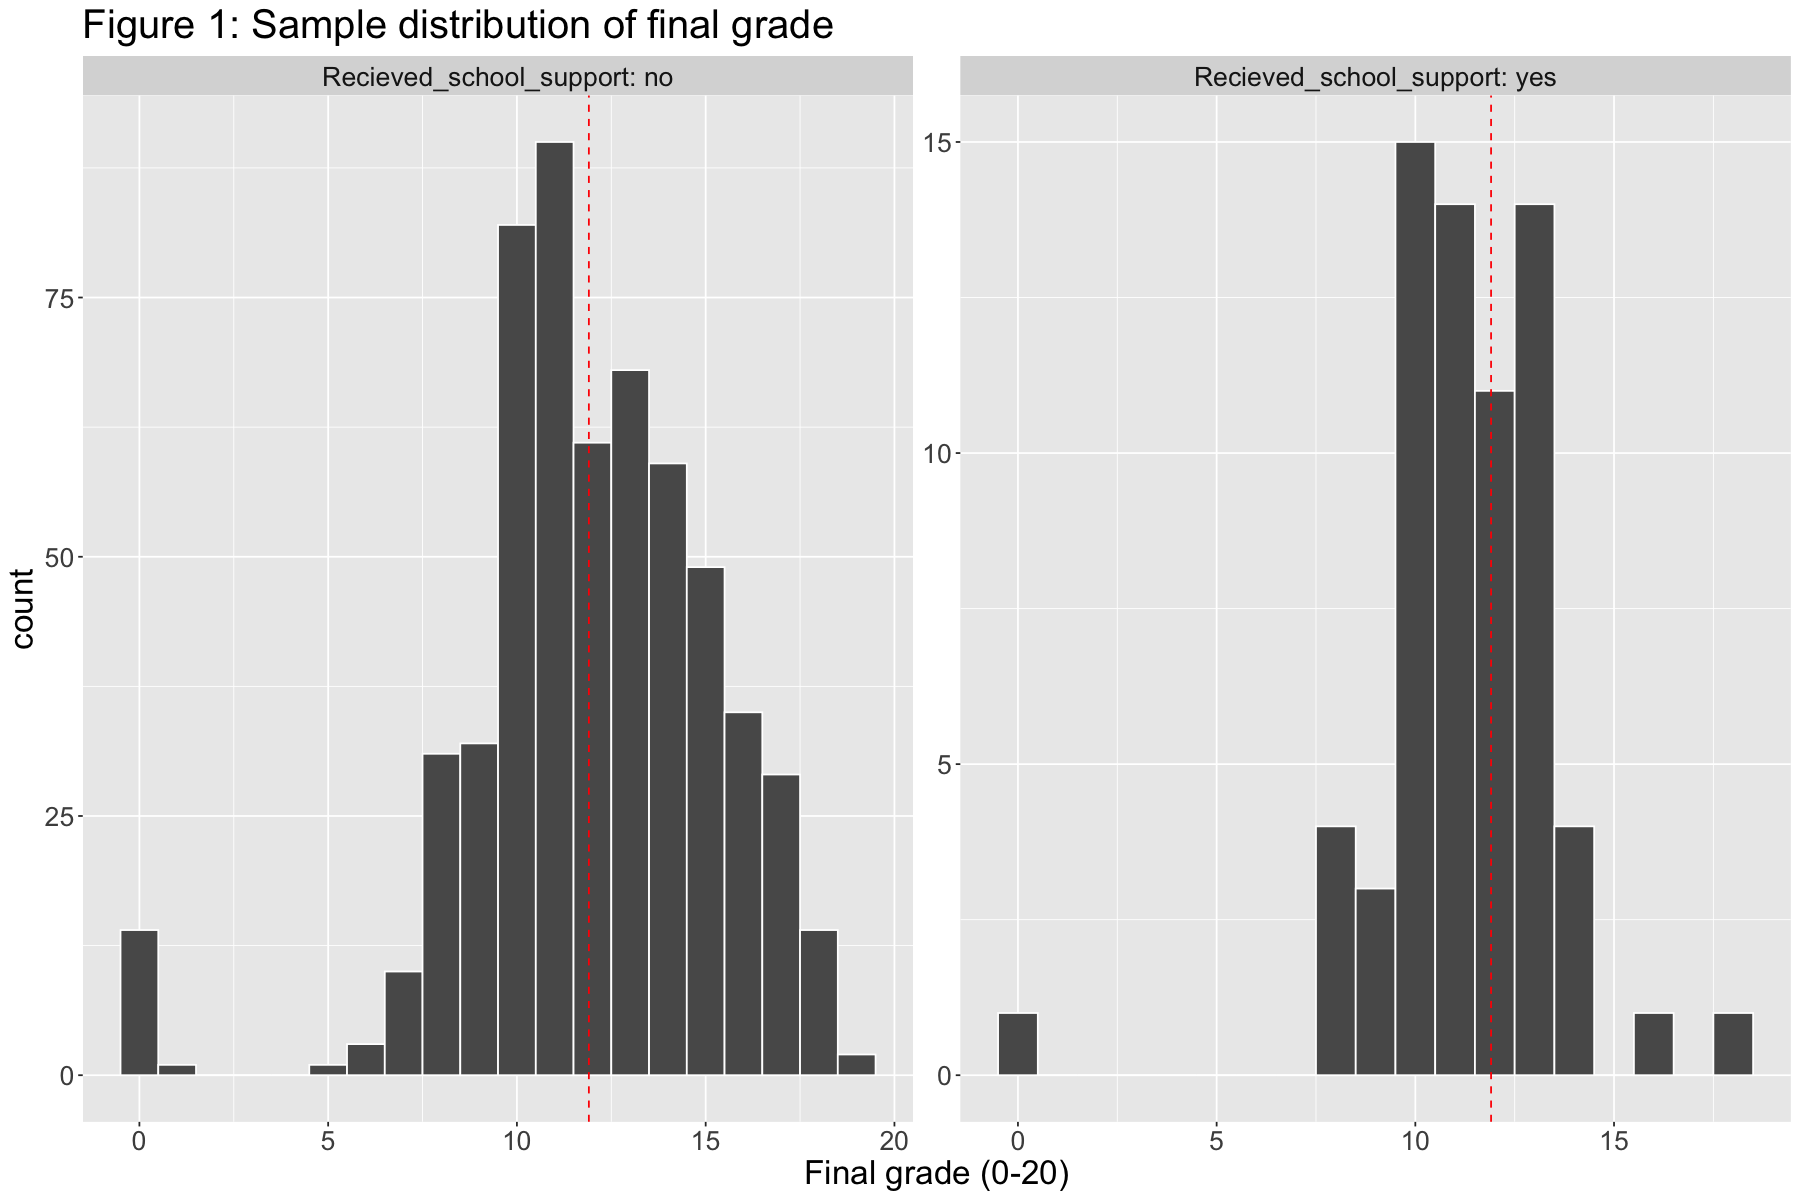

In [125]:
options(repr.plot.width = 15, repr.plot.height =10)
cs2 <- clean_student
colnames(cs2) <- c("Recieved_school_support","final_score")
sample_distribution <- cs2 %>%
                       ggplot()+
                       geom_histogram(aes(final_score),binwidth=1,color="white")+
                       geom_vline(aes(xintercept=mean(final_score)), color="red",
             linetype="dashed")+
                       ggtitle("Figure 1: Sample distribution of final grade")+
                       xlab("Final grade (0-20)")+
                       facet_wrap(vars(Recieved_school_support),scales = "free",labeller = label_both) +
                       theme(text = element_text(size = 20))
sample_distribution

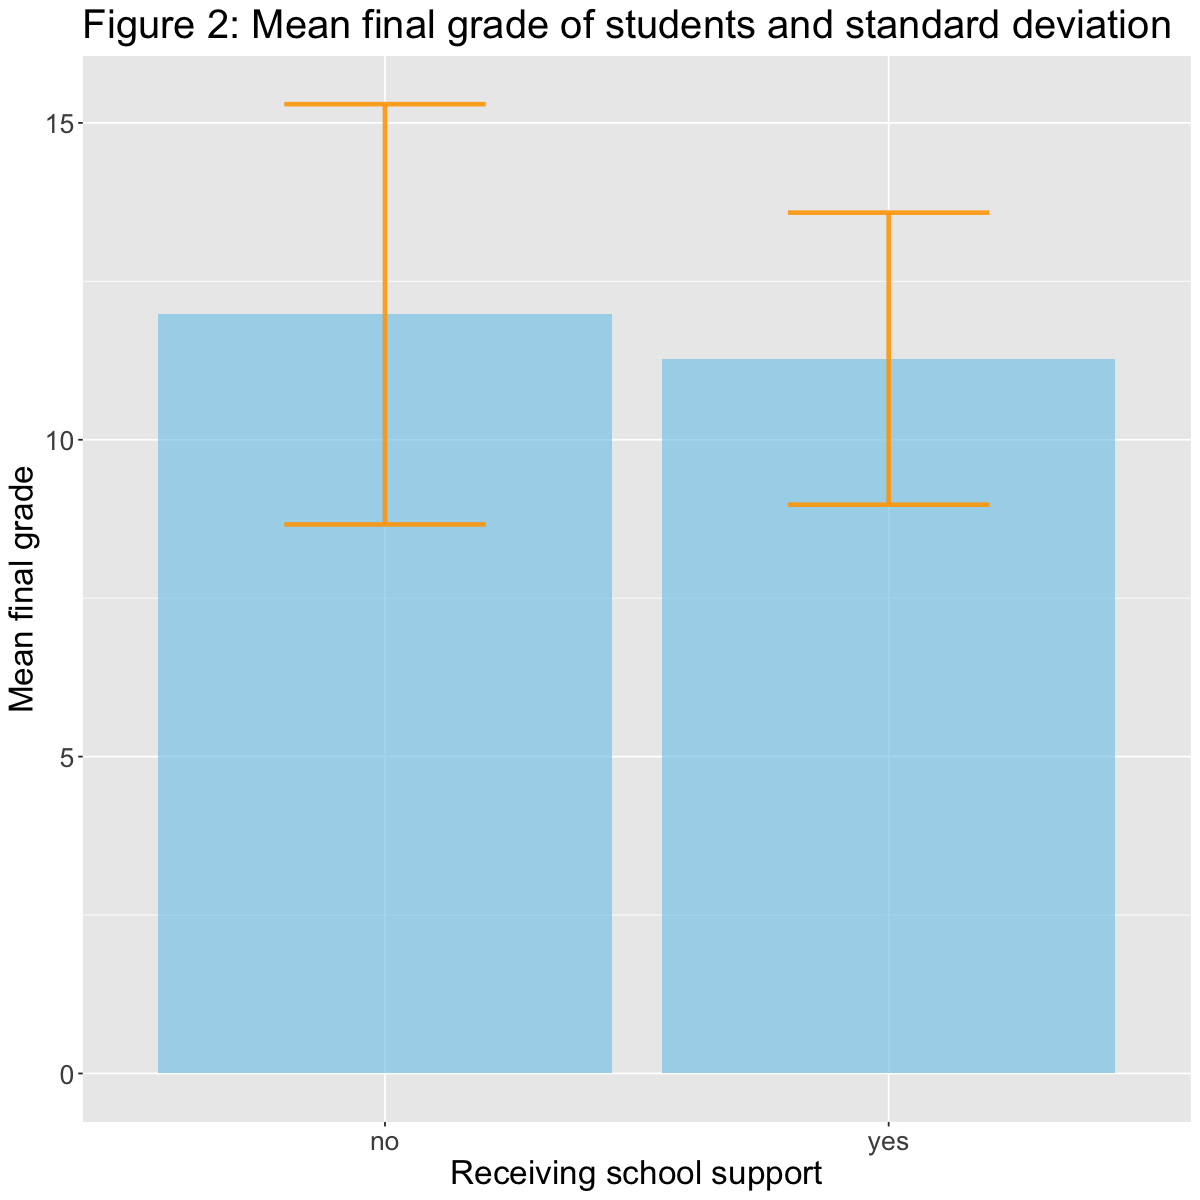

In [144]:
options(repr.plot.width = 10, repr.plot.height =10)
errorplot <- summary_student %>%
             ggplot()+
             geom_bar( aes(x=schoolsup, y=mean_final_grade), stat="identity", fill="skyblue", alpha=0.7) +
             geom_errorbar( aes(x=schoolsup, ymin=mean_final_grade-sd, ymax=mean_final_grade+sd), 
                           width=0.4, colour="orange", alpha=0.9, size=1.3)+
             ggtitle("Figure 2: Mean final grade of students and standard deviation")+
             labs(x= "Receiving school support", y = "Mean final grade")+
             theme(text = element_text(size = 20))
errorplot

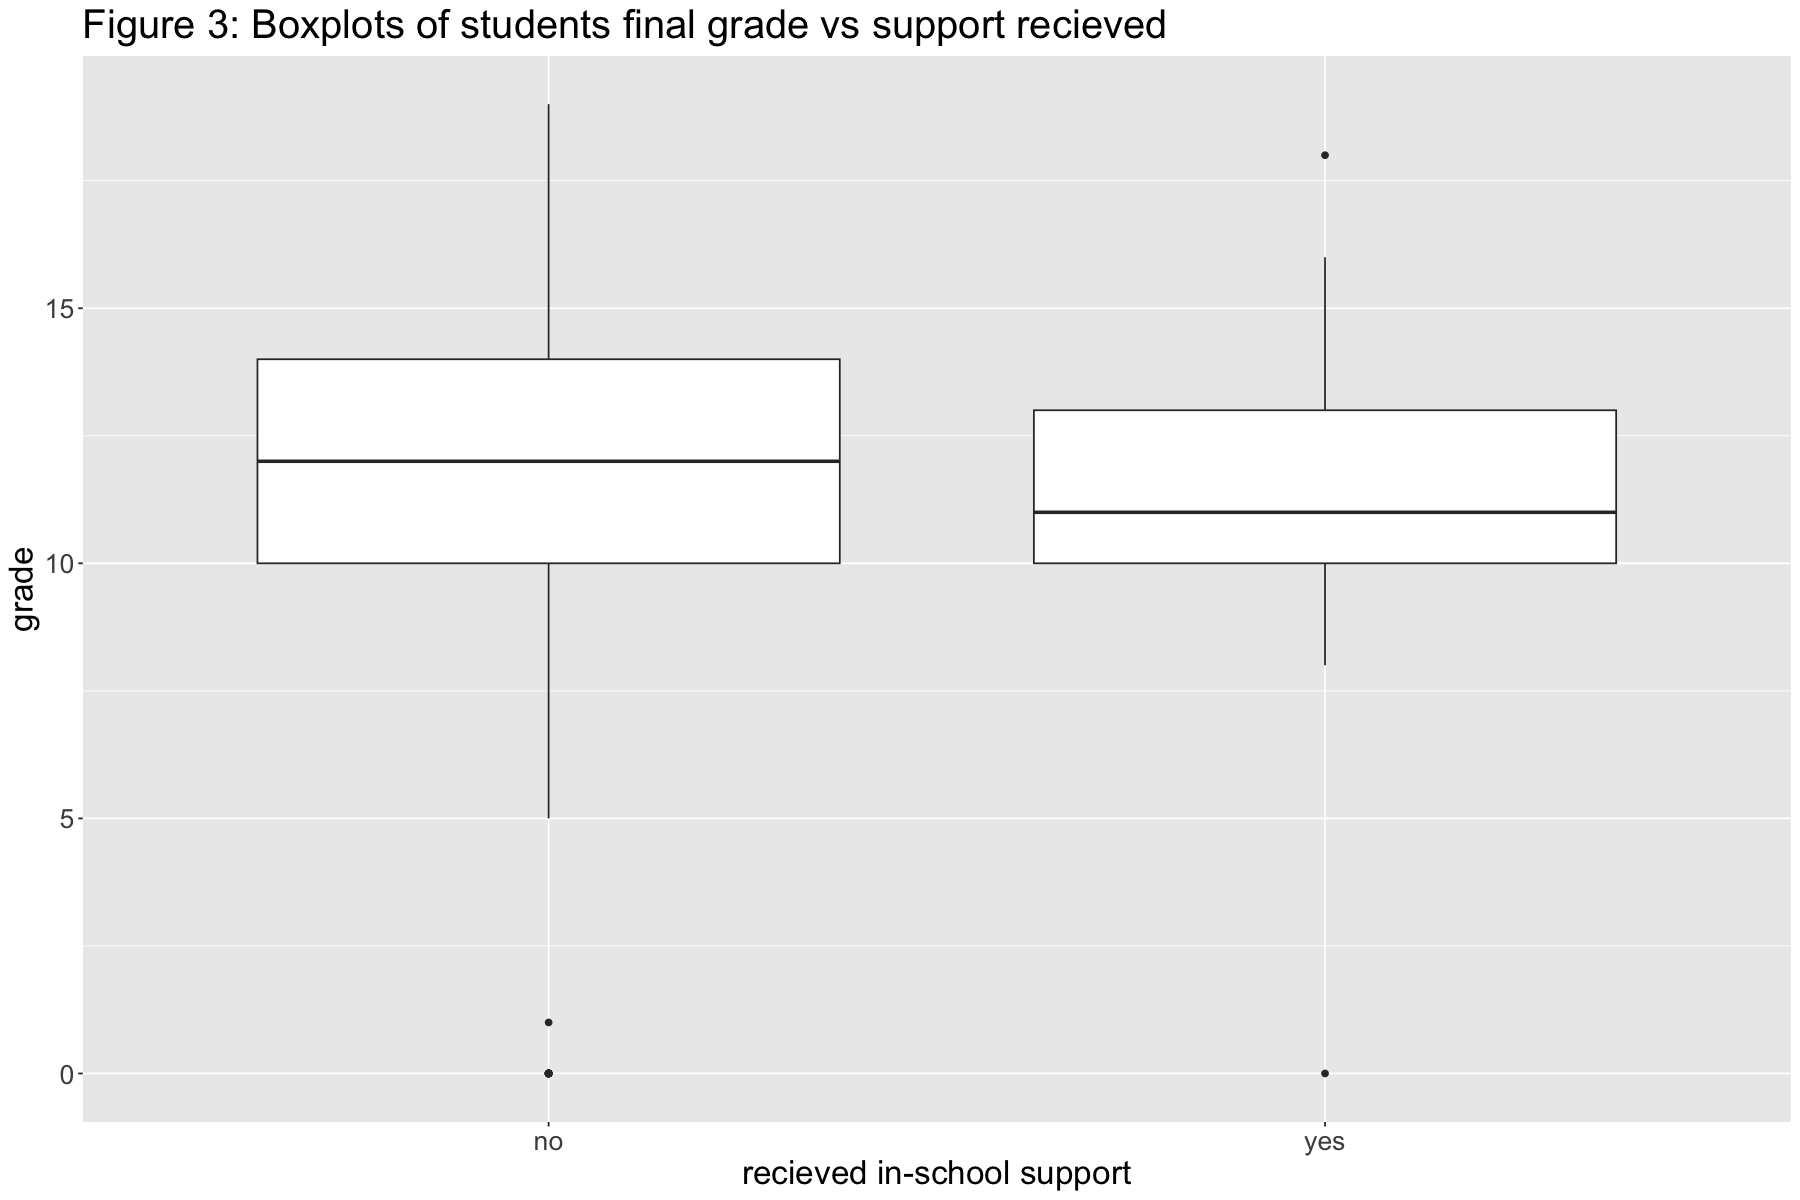

In [127]:
grades_boxplot <- clean_student |>
    ggplot(aes(x = schoolsup,y = G3)) +
    geom_boxplot() +
    ggtitle("Figure 3: Boxplots of students final grade vs support recieved")+
    labs(x = "recieved in-school support", y = "grade") + 
    theme(text = element_text(size = 20))

grades_boxplot

### Preliminary result discussion
- The dataset was collected at two random public schools from the Alentejo region of Portuguese by using school reports and questionnaires. Since the sample size is relatively large (n=649), and there is no bias in selecting schools. Then, we can say the sample is representative of the population of Portuguese student in the Alentejo region. Any result based on the sample can generalize to the population, and the point estimate is a “good guess” of the unknown population parameter. Thus, we can conclude that the report is trustworthy.

- While briefly viewing the sample distribution of grades between the two groups, we can see that the sample mean final grade of students who receive no extra educational support from the school is slightly higher than those who receive extra support from the school. However, we can see from the figure 1,2, and 3 that the range and variance between two sample mean overlap, therefore it is hard to conclude that the difference is not due to chance. Therefore, we need to do hypothesis testing to test for statistical significant result

## Method and Result
### Hypothesis testing for the mean

   Our hypothesis tests as followed:
   1. Hypothesis testing for difference in mean\
    - $H_0$: "The mean final grade of students receiving extra support from school" = "The mean final grade of students not receiving extra support from school"\
    - $H_A$: "The mean final grade of students receiving extra support from school" is larger to "The mean final grade of students not receiving extra support from school"
   
We will select a significance level to be: $\alpha = 0.05$

For hypothesis testing of the mean, we can use $t$-distribution hypothesis testing, since we don't know the true standard deviation of the 2 population of students receiving support is. Considering the condition for $t$-distribution hypothesis testing, since we don't know whether the difference of mean between the two group is normally distributed, we can use the Central Limit Theorem to apply the $t$-distribution. The conditions of the  
   In order to confirm that we satisfy the condition for the Central Limit, we need to make some assumption:
   1. The sample of the two population is randomly selected
   2. The sample of the two population is independent (i.e the sample size of the two population is larger than 30)
   3. The two sample are independent of each other
   
Since conditions are satisfied, we can use the CLT to conduct asymptotic based on $t$-distribution

Finding test-statistic using formula
$$
T = \frac{\bar{x}-\bar{y} - d_0}{\sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}} }
$$

$t$-distribution with approximately $\nu$ degrees of freedom, where 
$$
\nu = \frac{
    \left(\frac{s_1^2}{n_1}+\frac{s_2^2}{n_2}\right)^2
}
{
\frac{s_1^4}{n_1^2(n_1-1)}+\frac{s_2^4}{n_2^2(n_2-1)}
}
$$

In [128]:
#Finding p-value using formula
#Finding test-statistic

observed_test_stat <- (summary_student$mean_final_grade[2] - summary_student$mean_final_grade[1]) / sqrt((summary_student$sd[2])^2 /summary_student$n[2] + (summary_student$sd[1])^2 /summary_student$n[1])
sprintf("test_stat: %s", observed_test_stat)

#finding degrees of freedom 
#Number of students who receive school support and number of students who don't receive school support
n_yes <- summary_student$n[2]^2 * (summary_student$n[2] - 1)
n_no <- summary_student$n[1]^2 * (summary_student$n[1] - 1)

degrees <- (summary_student$sd[2]^2 /summary_student$n[2] + summary_student$sd[1]^2 /summary_student$n[1])^2 / (summary_student$sd[2]^4 / n_yes + summary_student$sd[1]^4/ n_no ) 
sprintf("degree of freedom: %s", degrees)

#p-value
p_value <- 2*pt(observed_test_stat, df= degrees,lower.tail=TRUE) 
sprintf("p_value: %s", p_value) 

[1] "test_stat: -2.24738639981879"

[1] "degree of freedom: 102.724846470766"

[1] "p_value: 0.0267533180277286"

Warning message:
“Check to make sure the conditions have been met for the theoretical method. {infer} currently does not check these for you.”


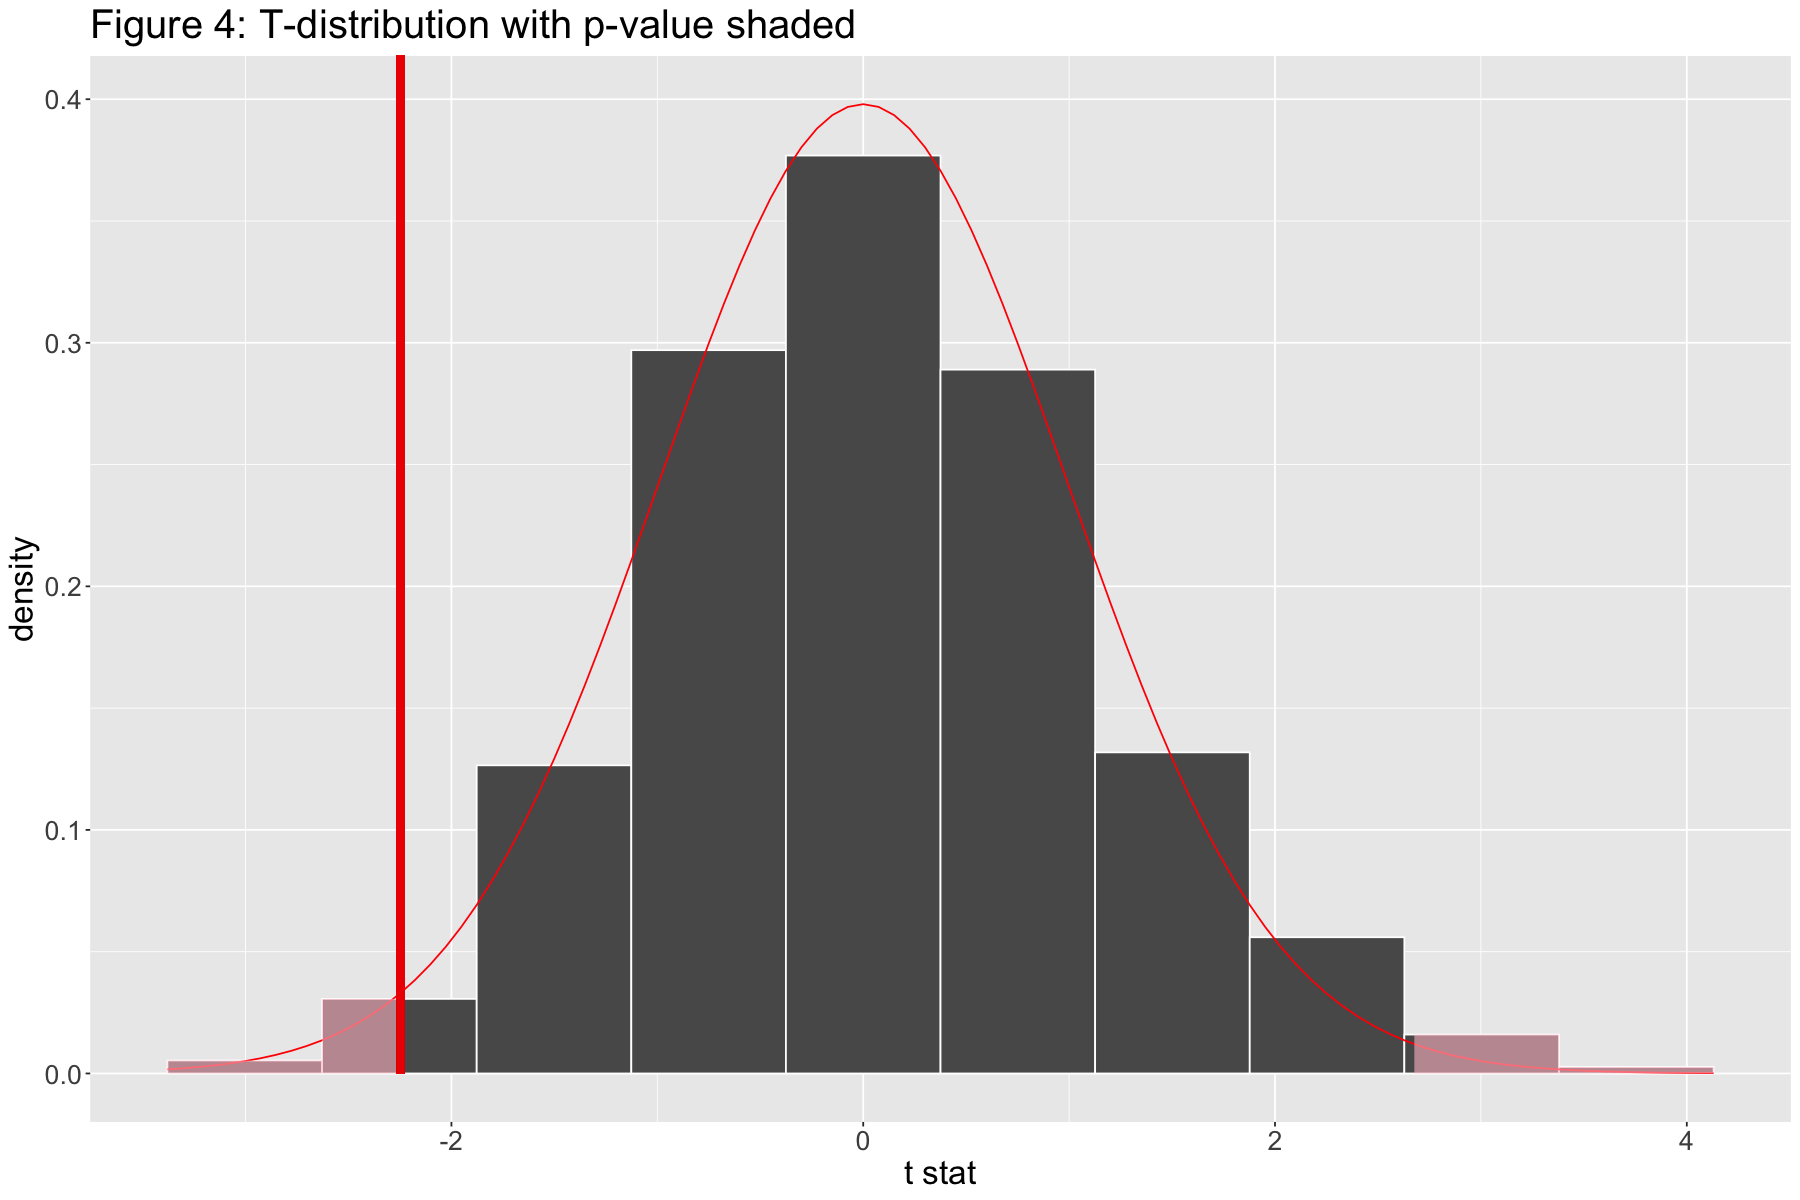

In [129]:
# Construct the t-distribution:
library(infer)
null_distribution <- clean_student %>% 
  specify(formula = G3 ~ schoolsup) %>% 
  hypothesize(null = "independence") %>% 
  generate(reps = 1000, type = "permute") %>% 
  calculate(stat = "t", order = c("yes", "no"))

#Plot the p-value that we calculated onto the t-distrbution
visualization <- null_distribution %>%
  visualize(null_distribution, method = "both", bins = 10, dens_color = "red") +
  shade_p_value(obs_stat = test_stat, direction = "both")+
  ggtitle("Figure 4: T-distribution with p-value shaded")+
  theme(text = element_text(size = 20))
visualization

### Confidence Interval for difference of mean:
- In order to enhance the accurarcy of our estimates, we can conduct a 95% confidence interval for the difference of mean, to see whether our finding in hypothesis testings is similar to the possible values of the confidence interval. The Confidence interval can be built using the asymptotic method or bootstrapping. Both methods work for our dataset. However, we will decide to use the bootstrapping method since we won't have to rely on the sample standard deviation, as well as concerns whether the sample statisfies the condition of the Central Limit Theorem. In addition, the bootstrapping will give us a more consistent and accurate estimate of the confidence interval.

- The 95% confidence interval will indicate to us the range of possible values the difference of the two population mean grade. Since we use students with school-support mean grade minus students with no school support mean grade, this means that if our confidence interval has negative range then the mean grade of student with no support is higher than the mean grade of student with support, and if the range is positive then vice versa. In addition, if the range has 0, it indicates to us that it is possible for that there's no difference between mean grade of the two population.

In [130]:
#Building Confidence Interval for the difference of mean:
diff_mean_bootstrap_ci <- clean_student %>%
    specify(formula = G3 ~ schoolsup)%>%
    generate(reps = 1000, type = "bootstrap") %>%
    calculate(stat = "diff in means", order = c("yes", "no")) %>%
    get_confidence_interval(level = 0.95, type = "percentile")
diff_mean_bootstrap_ci


lower_ci,upper_ci
<dbl>,<dbl>
-1.31399,-0.1301172


<em> Table 4: Confidence Interval for Difference of Mean of final grade</em>

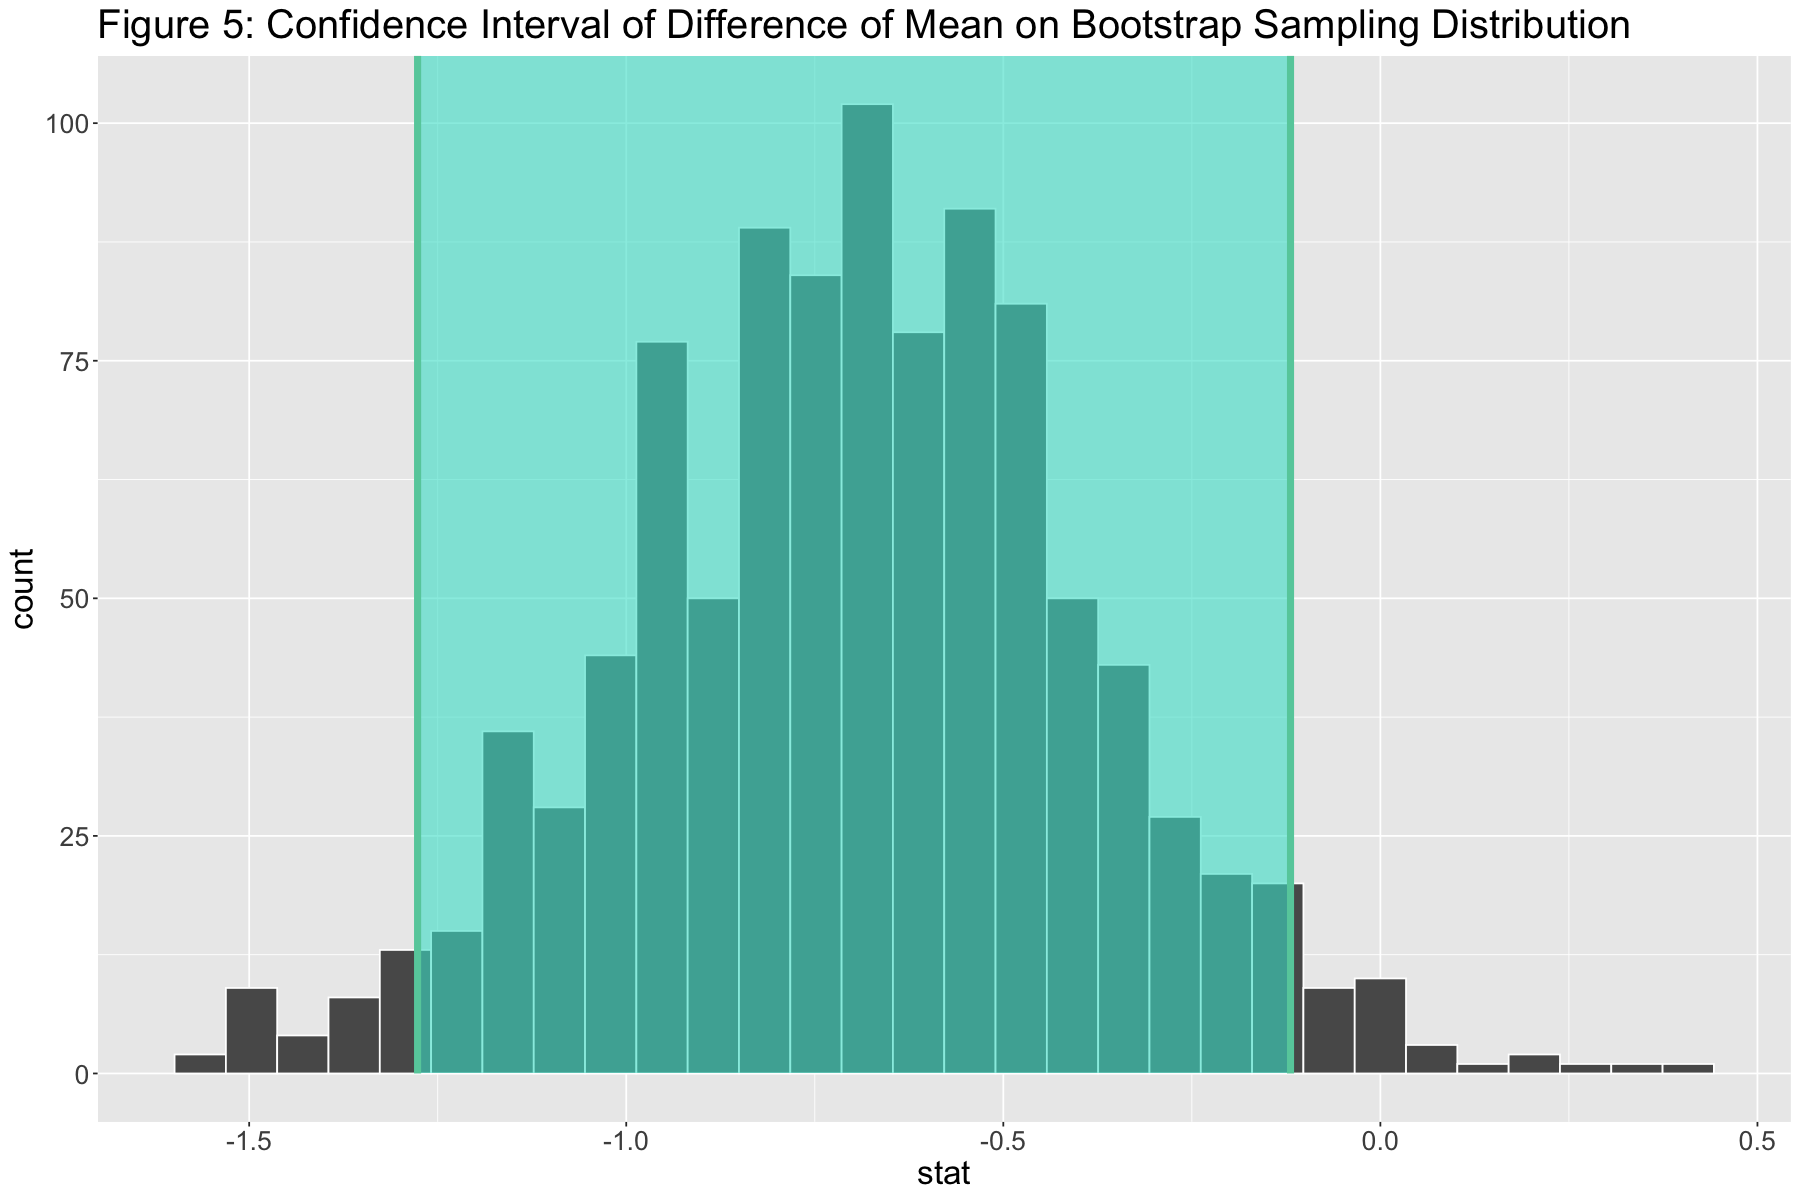

In [131]:
#Building the sampling distribution for the difference of mean of the two sample
diff_mean_bootstrap_dist <- clean_student %>%
    specify(formula = G3 ~ schoolsup)%>%
    generate(reps = 1000, type = "bootstrap") %>%
    calculate(stat = "diff in means", order = c("yes", "no"))

#Plotting the confidence interval onto the sampling distribution
diff_mean_ci_bootstrap_plot <- 
    visualize(diff_mean_bootstrap_dist,bin=30) +
    theme(text = element_text(size = 20)) +
    ggtitle("Figure 5: Confidence Interval of Difference of Mean on Bootstrap Sampling Distribution")+
    shade_confidence_interval(endpoints = bootstrap_ci)
diff_mean_ci_bootstrap_plot

## Discussion

**Findings:**
1. Through our hypothesis testing, we found out that we have enough evidence to reject the null hypothesis. This means that there's a difference between the two mean grade of the two populations: those who received school support those who did not.
2. Building confidence interval, we learnt that students with no school support received higher mean grade than the students with school support, which correlates to the negative range.

**The result of hypothesis testing is within our expected, but the confidence interval finding is surprising for us**

While there is a difference in mean grade between two groups, it was suprising to find out that students not receiving school support got higher results. We expected completly opposite correlation according to the research papers we read; however, this difference could be due to multiple factors like student's finacnial status, his engagement with school, and whether they take tutoring outside school. All these elements have to be taken into account to get a better understanding of the subject.

Based on our resutls, there could be action taken into enhancing support level provided from school. With further research, school board can find confound relationship between several factors like mean and grade and student's family status. Understanding these relationships between student performance and additional factos lays the foundation for change and creates new educational strategies (Odden & Archibald, 2001).
      
**Future questions:**
- What other factors can be compared to see any substantial differences or trends?
- How can we effectively and efficiently implement ways of improving students’ support from teachers?

References:\
Cortez, P., & Silva, A. (2008). Using data mining to predict secondary school student performance. EUROSIS.

Klem, A. M., & Connell, J. P. (2004). Relationships Matter: Linking Teacher Support to Student Engagement and Achievement. Journal of School Health, 74(7), 262–273. https://doi.org/10.1111/j.1746-1561.2004.tb08283.x

Odden, A., & Archibald, S. (2001). Reallocating Resources: How to Boost Student Achievement Without Asking for More. SAGE Publications. https://books.google.com/books?id=QkZmgMvKoRcC 

word count: 1277